In [1]:
# import dependencies
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.preprocessing import StandardScaler
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import extract
import sqlite3 as sql
import matplotlib.pyplot as plt

In [2]:
# load data
db = sqlalchemy.create_engine('sqlite:///movies.sqlite')
imdb_df = pd.read_sql('select * from movies', db)
imdb_df

,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,director,...,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,tt0000009,Miss Jerry,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,...,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,None,None,None,None,1.0,2.0
1,tt0000574,The Story of the Kelly Gang,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,...,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,$ 2250,None,None,None,7.0,7.0
2,tt0001892,Den sorte drøm,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",None,Urban Gad,...,"Asta Nielsen, Valdemar Psilander, Gunnar Helse...",Two men of high rank are both wooing the beaut...,5.8,188,None,None,None,None,5.0,2.0
3,tt0002101,Cleopatra,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,...,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,$ 45000,None,None,None,25.0,3.0
4,tt0002130,L'Inferno,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",...,"Salvatore Papa, Arturo Pirovano, Giuseppe de L...",Loosely adapted from Dante's Divine Comedy and...,7.0,2237,None,None,None,None,31.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85850,tt9908390,Le lion,Le lion,2020,2020-01-29,Comedy,95,"France, Belgium",French,Ludovic Colbeau-Justin,...,"Dany Boon, Philippe Katerine, Anne Serra, Samu...",A psychiatric hospital patient pretends to be ...,5.3,398,None,None,$ 3507171,None,None,4.0
85851,tt9911196,De Beentjes van Sint-Hildegard,De Beentjes van Sint-Hildegard,2020,2020-02-13,"Comedy, Drama",103,Netherlands,"German, Dutch",Johan Nijenhuis,...,"Herman Finkers, Johanna ter Steege, Leonie ter...",A middle-aged veterinary surgeon believes his ...,7.7,724,None,None,$ 7299062,None,6.0,4.0
85852,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,2019-03-08,Drama,130,India,Malayalam,Vineesh Aaradya,...,"Anoop Chandran, Indrans, Sona Nair, Simon Brit...",None,7.9,265,None,None,None,None,None,None
85853,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,2019-03-15,"Drama, Family",98,Turkey,Turkish,Ahmet Faik Akinci,...,"Ahmet Faik Akinci, Belma Mamati, Metin Keçeci,...",None,6.4,194,None,None,$ 2833,None,None,None


In [3]:
# open a connection to database
conn = sql.connect('movies.db')

In [4]:
imdb_df.columns

Index(['imdb_title_id', 'title', 'original_title', 'year', 'date_published',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

In [5]:
# drop columns
imdb_df = imdb_df.drop(columns=['imdb_title_id', 'original_title', 'writer', 'production_company', 'actors','description'])
imdb_df

,title,year,date_published,genre,duration,country,language,director,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,Miss Jerry,1894,1894-10-09,Romance,45,USA,None,Alexander Black,5.9,154,None,None,None,None,1.0,2.0
1,The Story of the Kelly Gang,1906,1906-12-26,"Biography, Crime, Drama",70,Australia,None,Charles Tait,6.1,589,$ 2250,None,None,None,7.0,7.0
2,Den sorte drøm,1911,1911-08-19,Drama,53,"Germany, Denmark",None,Urban Gad,5.8,188,None,None,None,None,5.0,2.0
3,Cleopatra,1912,1912-11-13,"Drama, History",100,USA,English,Charles L. Gaskill,5.2,446,$ 45000,None,None,None,25.0,3.0
4,L'Inferno,1911,1911-03-06,"Adventure, Drama, Fantasy",68,Italy,Italian,"Francesco Bertolini, Adolfo Padovan",7.0,2237,None,None,None,None,31.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85850,Le lion,2020,2020-01-29,Comedy,95,"France, Belgium",French,Ludovic Colbeau-Justin,5.3,398,None,None,$ 3507171,None,None,4.0
85851,De Beentjes van Sint-Hildegard,2020,2020-02-13,"Comedy, Drama",103,Netherlands,"German, Dutch",Johan Nijenhuis,7.7,724,None,None,$ 7299062,None,6.0,4.0
85852,Padmavyuhathile Abhimanyu,2019,2019-03-08,Drama,130,India,Malayalam,Vineesh Aaradya,7.9,265,None,None,None,None,None,None
85853,Sokagin Çocuklari,2019,2019-03-15,"Drama, Family",98,Turkey,Turkish,Ahmet Faik Akinci,6.4,194,None,None,$ 2833,None,None,None


In [6]:
# drop nulls
imdb_df = imdb_df.dropna()

In [7]:
imdb_df

,title,year,date_published,genre,duration,country,language,director,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
506,Metropolis,1927,1928-10-01,"Drama, Sci-Fi",153,Germany,German,Fritz Lang,8.3,156076,DEM 6000000,$ 1236166,$ 1349711,98.0,495.0,208.0
1048,Luci della città,1931,1931-04-02,"Comedy, Drama, Romance",87,USA,English,Charles Chaplin,8.5,162668,$ 1500000,$ 19181,$ 46008,99.0,295.0,122.0
2454,Tempi moderni,1936,1937-03-12,"Comedy, Drama, Family",87,USA,English,Charles Chaplin,8.5,211250,$ 1500000,$ 163577,$ 457688,96.0,307.0,115.0
2795,Il bandito della Casbah,1937,1937-10-22,"Crime, Drama, Romance",94,France,"French, Arabic",Julien Duvivier,7.7,6180,$ 60000,$ 155895,$ 155895,98.0,46.0,55.0
2827,Biancaneve e i sette nani,1937,1938-11-30,"Animation, Family, Fantasy",83,USA,English,"William Cottrell, David Hand",7.6,177157,$ 1499000,$ 184925486,$ 184925486,95.0,260.0,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85266,Impractical Jokers: The Movie,2020,2020-02-28,Comedy,92,USA,English,Chris Henchy,5.9,4105,$ 3000000,$ 10691091,$ 10691091,39.0,152.0,17.0
85274,Emma.,2020,2020-03-27,"Comedy, Drama",124,UK,English,Autumn de Wilde,6.7,19858,$ 10000000,$ 10055355,$ 25659965,71.0,314.0,188.0
85397,Jexi,2019,2019-10-11,"Comedy, Romance",84,"USA, Canada",English,"Jon Lucas, Scott Moore",6.1,17038,$ 5000000,$ 6546159,$ 9341824,39.0,234.0,42.0
85460,Weathering with You,2019,2019-10-14,"Animation, Drama, Family",112,"Japan, China",Japanese,Makoto Shinkai,7.6,16277,$ 11100000,$ 7798743,$ 193176979,72.0,177.0,110.0


In [8]:
imdb_df['budget'] = pd.to_numeric(imdb_df['budget'].replace('[\DEM]','',regex=True))

In [9]:
imdb_df

,title,year,date_published,genre,duration,country,language,director,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
506,Metropolis,1927,1928-10-01,"Drama, Sci-Fi",153,Germany,German,Fritz Lang,8.3,156076,6000000,$ 1236166,$ 1349711,98.0,495.0,208.0
1048,Luci della città,1931,1931-04-02,"Comedy, Drama, Romance",87,USA,English,Charles Chaplin,8.5,162668,1500000,$ 19181,$ 46008,99.0,295.0,122.0
2454,Tempi moderni,1936,1937-03-12,"Comedy, Drama, Family",87,USA,English,Charles Chaplin,8.5,211250,1500000,$ 163577,$ 457688,96.0,307.0,115.0
2795,Il bandito della Casbah,1937,1937-10-22,"Crime, Drama, Romance",94,France,"French, Arabic",Julien Duvivier,7.7,6180,60000,$ 155895,$ 155895,98.0,46.0,55.0
2827,Biancaneve e i sette nani,1937,1938-11-30,"Animation, Family, Fantasy",83,USA,English,"William Cottrell, David Hand",7.6,177157,1499000,$ 184925486,$ 184925486,95.0,260.0,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85266,Impractical Jokers: The Movie,2020,2020-02-28,Comedy,92,USA,English,Chris Henchy,5.9,4105,3000000,$ 10691091,$ 10691091,39.0,152.0,17.0
85274,Emma.,2020,2020-03-27,"Comedy, Drama",124,UK,English,Autumn de Wilde,6.7,19858,10000000,$ 10055355,$ 25659965,71.0,314.0,188.0
85397,Jexi,2019,2019-10-11,"Comedy, Romance",84,"USA, Canada",English,"Jon Lucas, Scott Moore",6.1,17038,5000000,$ 6546159,$ 9341824,39.0,234.0,42.0
85460,Weathering with You,2019,2019-10-14,"Animation, Drama, Family",112,"Japan, China",Japanese,Makoto Shinkai,7.6,16277,11100000,$ 7798743,$ 193176979,72.0,177.0,110.0


In [10]:
# convert columns with $ to numeric
imdb_df[imdb_df.columns[11:12]] = imdb_df[imdb_df.columns[11:12]].replace('[\$]','',regex=True).astype(float)
imdb_df

,title,year,date_published,genre,duration,country,language,director,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
506,Metropolis,1927,1928-10-01,"Drama, Sci-Fi",153,Germany,German,Fritz Lang,8.3,156076,6000000,1236166.0,$ 1349711,98.0,495.0,208.0
1048,Luci della città,1931,1931-04-02,"Comedy, Drama, Romance",87,USA,English,Charles Chaplin,8.5,162668,1500000,19181.0,$ 46008,99.0,295.0,122.0
2454,Tempi moderni,1936,1937-03-12,"Comedy, Drama, Family",87,USA,English,Charles Chaplin,8.5,211250,1500000,163577.0,$ 457688,96.0,307.0,115.0
2795,Il bandito della Casbah,1937,1937-10-22,"Crime, Drama, Romance",94,France,"French, Arabic",Julien Duvivier,7.7,6180,60000,155895.0,$ 155895,98.0,46.0,55.0
2827,Biancaneve e i sette nani,1937,1938-11-30,"Animation, Family, Fantasy",83,USA,English,"William Cottrell, David Hand",7.6,177157,1499000,184925486.0,$ 184925486,95.0,260.0,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85266,Impractical Jokers: The Movie,2020,2020-02-28,Comedy,92,USA,English,Chris Henchy,5.9,4105,3000000,10691091.0,$ 10691091,39.0,152.0,17.0
85274,Emma.,2020,2020-03-27,"Comedy, Drama",124,UK,English,Autumn de Wilde,6.7,19858,10000000,10055355.0,$ 25659965,71.0,314.0,188.0
85397,Jexi,2019,2019-10-11,"Comedy, Romance",84,"USA, Canada",English,"Jon Lucas, Scott Moore",6.1,17038,5000000,6546159.0,$ 9341824,39.0,234.0,42.0
85460,Weathering with You,2019,2019-10-14,"Animation, Drama, Family",112,"Japan, China",Japanese,Makoto Shinkai,7.6,16277,11100000,7798743.0,$ 193176979,72.0,177.0,110.0


In [11]:
imdb_df['worlwide_gross_income'] = pd.to_numeric(imdb_df['worlwide_gross_income'].replace('[\$]','',regex=True))

In [12]:
imdb_df.head(10)

,title,year,date_published,genre,duration,country,language,director,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
506,Metropolis,1927,1928-10-01,"Drama, Sci-Fi",153,Germany,German,Fritz Lang,8.3,156076,6000000,1236166.0,1349711,98.0,495.0,208.0
1048,Luci della città,1931,1931-04-02,"Comedy, Drama, Romance",87,USA,English,Charles Chaplin,8.5,162668,1500000,19181.0,46008,99.0,295.0,122.0
2454,Tempi moderni,1936,1937-03-12,"Comedy, Drama, Family",87,USA,English,Charles Chaplin,8.5,211250,1500000,163577.0,457688,96.0,307.0,115.0
2795,Il bandito della Casbah,1937,1937-10-22,"Crime, Drama, Romance",94,France,"French, Arabic",Julien Duvivier,7.7,6180,60000,155895.0,155895,98.0,46.0,55.0
2827,Biancaneve e i sette nani,1937,1938-11-30,"Animation, Family, Fantasy",83,USA,English,"William Cottrell, David Hand",7.6,177157,1499000,184925486.0,184925486,95.0,260.0,173.0
3266,Via col vento,1939,1949-03-12,"Drama, History, Romance",238,USA,English,"Victor Fleming, George Cukor",8.1,283975,3977000,200852579.0,402352579,97.0,881.0,197.0
3348,Mr. Smith va a Washington,1939,1947-04-05,"Comedy, Drama",129,USA,English,Frank Capra,8.1,104547,1900000,144738.0,144738,73.0,296.0,88.0
3451,Il mago di Oz,1939,1949-04-19,"Adventure, Family, Fantasy",102,USA,English,"Victor Fleming, George Cukor",8.0,366293,2777000,24790250.0,26142032,100.0,688.0,168.0
3553,Fantasia,1940,1946-09-19,"Animation, Family, Fantasy",125,USA,English,"James Algar, Samuel Armstrong",7.8,86795,2280000,76408097.0,76411401,96.0,342.0,119.0
3672,Pinocchio,1940,1947-11-27,"Animation, Comedy, Family",88,USA,English,"Norman Ferguson, T. Hee",7.4,127618,2600000,84254167.0,121892045,99.0,202.0,140.0


In [13]:
# check unique values
imdb_df.nunique()

title                    6582
year                       81
date_published           3250
genre                     394
duration                  140
country                  1022
language                  987
director                 2983
avg_vote                   74
votes                    6434
budget                    567
usa_gross_income         6632
worlwide_gross_income    6638
metascore                  97
reviews_from_users       1173
reviews_from_critics      594
dtype: int64

In [14]:
imdb_df.dtypes

title                     object
year                      object
date_published            object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
avg_vote                 float64
votes                      int64
budget                     int64
usa_gross_income         float64
worlwide_gross_income      int64
metascore                 object
reviews_from_users        object
reviews_from_critics      object
dtype: object

In [15]:
meta_counts = imdb_df.metascore.value_counts()
meta_counts

66.0    149
55.0    144
64.0    142
52.0    141
45.0    141
       ... 
1.0       3
7.0       3
8.0       1
6.0       1
5.0       1
Name: metascore, Length: 97, dtype: int64

In [17]:
pd.cut(imdb_df['metascore'].astype(float),bins=4)

506      (75.25, 100.0]
1048     (75.25, 100.0]
2454     (75.25, 100.0]
2795     (75.25, 100.0]
2827     (75.25, 100.0]
              ...      
85266     (25.75, 50.5]
85274     (50.5, 75.25]
85397     (25.75, 50.5]
85460     (50.5, 75.25]
85740     (25.75, 50.5]
Name: metascore, Length: 6640, dtype: category
Categories (4, interval[float64]): [(0.901, 25.75] < (25.75, 50.5] < (50.5, 75.25] < (75.25, 100.0]]

<AxesSubplot:ylabel='Density'>

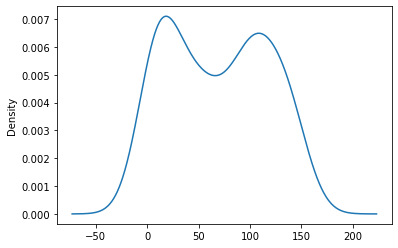

In [18]:
# visualize the value counts of metascore
meta_counts.plot.density()

In [27]:
# change metascore and title data types to float
imdb_df['metascore']=imdb_df['metascore'].astype(float)

In [20]:
imdb_df.dtypes

title                     object
year                      object
date_published            object
genre                     object
duration                   int64
country                   object
language                  object
director                  object
avg_vote                 float64
votes                      int64
budget                     int64
usa_gross_income         float64
worlwide_gross_income      int64
metascore                float64
reviews_from_users        object
reviews_from_critics      object
dtype: object

In [21]:
# create a new column 'hit'
def f(row):
    if float(row['metascore']) >= 75.0:
        val = '1'
    else:
        val = '0'
    return val

imdb_df['hit'] = imdb_df.apply(f, axis=1)

imdb_df

,title,year,date_published,genre,duration,country,language,director,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,hit
506,Metropolis,1927,1928-10-01,"Drama, Sci-Fi",153,Germany,German,Fritz Lang,8.3,156076,6000000,1236166.0,1349711,98.0,495.0,208.0,1
1048,Luci della città,1931,1931-04-02,"Comedy, Drama, Romance",87,USA,English,Charles Chaplin,8.5,162668,1500000,19181.0,46008,99.0,295.0,122.0,1
2454,Tempi moderni,1936,1937-03-12,"Comedy, Drama, Family",87,USA,English,Charles Chaplin,8.5,211250,1500000,163577.0,457688,96.0,307.0,115.0,1
2795,Il bandito della Casbah,1937,1937-10-22,"Crime, Drama, Romance",94,France,"French, Arabic",Julien Duvivier,7.7,6180,60000,155895.0,155895,98.0,46.0,55.0,1
2827,Biancaneve e i sette nani,1937,1938-11-30,"Animation, Family, Fantasy",83,USA,English,"William Cottrell, David Hand",7.6,177157,1499000,184925486.0,184925486,95.0,260.0,173.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85266,Impractical Jokers: The Movie,2020,2020-02-28,Comedy,92,USA,English,Chris Henchy,5.9,4105,3000000,10691091.0,10691091,39.0,152.0,17.0,0
85274,Emma.,2020,2020-03-27,"Comedy, Drama",124,UK,English,Autumn de Wilde,6.7,19858,10000000,10055355.0,25659965,71.0,314.0,188.0,0
85397,Jexi,2019,2019-10-11,"Comedy, Romance",84,"USA, Canada",English,"Jon Lucas, Scott Moore",6.1,17038,5000000,6546159.0,9341824,39.0,234.0,42.0,0
85460,Weathering with You,2019,2019-10-14,"Animation, Drama, Family",112,"Japan, China",Japanese,Makoto Shinkai,7.6,16277,11100000,7798743.0,193176979,72.0,177.0,110.0,0


In [28]:
# seperate the features(X) from the target (y)
y = imdb_df['hit']
X = pd.get_dummies(imdb_df.drop(columns='hit'))

# split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1, stratify = y)
X_train.shape

(4980, 17073)

In [24]:
classifier = LogisticRegression(solver='lbfgs', max_iter = 200, random_state = 1)

In [29]:
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=200, random_state=1)

In [30]:
y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)

In [31]:
results.head(20)

,Prediction,Actual
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [32]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.8325301204819278


In [33]:
from sklearn.metrics import confusion_matrix, classification_report
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[1328   82]
 [ 196   54]]


In [34]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      1410
           1       0.40      0.22      0.28       250

    accuracy                           0.83      1660
   macro avg       0.63      0.58      0.59      1660
weighted avg       0.80      0.83      0.81      1660

